In [1]:
%matplotlib inline
import pdb

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 22 23:37:03 2017

@author: mjb
"""
import sys
sys.path.append('../../')

import torch
import numpy as np
import Settings.arguments as arguments
import Settings.game_settings as game_settings
import Settings.constants as constants
# from Player.six_player_machine import SixPlayerMachine
# from ACPC.six_acpc_game import SixACPCGame
from Tree.game_state import GameState
from Tree.game_state import Action
from nn.sim_env import SimEnv

from nn.dqn import *
from nn.table_sl import TableSL
from nn.net_sl import SLOptim
from nn.maddpg import MADDPG

import seaborn as sns
from sklearn import manifold
import pandas as pd

In [3]:
# iter_num = [10000,20000,30000]
iter_num = [100000,110000,120000]
def load_model(episoid):
    net_sl = SLOptim()
    net_rl = DQNOptim()
    maddpg = MADDPG()
    
#     net_sl.model.load_state_dict(torch.load( \
#                                 arguments.WORK_PATH+'/Data/Model/Iter:' + str(episoid) + '_' + str(0) +'_' + '.sl'))
#     net_sl.model.eval()
#     net_rl.model.load_state_dict(torch.load( \
#                                 arguments.WORK_PATH+'/Data/Model/Iter:' + str(episoid) + '_' + str(0) +'_' + '.rl'))
#     net_rl.model.eval()
    
    for i in range(game_settings.player_count):
        maddpg.actors[i].load_state_dict(torch.load( \
            arguments.WORK_PATH+'/Data/Model/Iter:' + str(episoid) + '_' + str(i) +'.actor'))
        maddpg.actors[i].load_state_dict(torch.load( \
            arguments.WORK_PATH+'/Data/Model/Iter:' + str(episoid) + '_' + str(i) +'.actor'))
    return net_sl, net_rl, maddpg

state = GameState()
call = Action(atype=constants.actions.ccall,amount=0)
rrasie = Action(atype=constants.actions.rraise,amount=1000)
fold = Action(atype=constants.actions.fold,amount=0)

env = SimEnv()


def make_data(size=10000):
    cat = []
    data = []

    for _ in range(size):
        state = GameState()
        state.street = np.random.randint(2)
        state.current_player = np.random.randint(3)
        state.terminal = True

        state.hole = torch.LongTensor(3, 1).fill_(0)
        state.hole[state.current_player][0] = np.random.randint(10)
        # board = torch.LongTensor([6,30,31,38,43])
        state.board = torch.LongTensor([6])
        state.bets = arguments.LongTensor(np.random.randint(arguments.stack, size=3))
        state.do_action(call)
        state.do_action(rrasie)
        state.do_action(call)
        state.do_action(fold)

        state_tensor = env.state2tensor(state)

        cat.append((state.hole[state.current_player].item(), state.street))
        data.append(state_tensor)

    return cat, data

def tsne(forward_data):
    tsne = manifold.TSNE(n_components=2, init='pca',
                             random_state=0, perplexity=50)
    fc1_x = tsne.fit_transform(forward_data)
    return fc1_x

def plot(fc1_x, target):
    df_data = np.append(fc1_x, np.array(target).reshape((-1,1)) ,axis=1)
    df = pd.DataFrame(columns=['x','y','tar'],data=df_data)
    df['tar'] = (df['tar'] / 4).astype(int)
    sns.lmplot(x='x', y='y', data=df,
               fit_reg=False, # No regression line
               hue='tar',
               scatter_kws={"s": 5})   # Color by evolution stage
    return df
cat, data = make_data(5000)
hole_tar, street_tar = list(zip(*cat))

读取模型参数，并利用上一个cell生成的数据画tsne图

In [4]:
all_data = []
for it in iter_num:
    net_sl, net_rl, maddpg = load_model(it)
    net_sl = SLOptim()
    net_sl.model.eval()
    net_rl = DQNOptim()
    net_rl.model.eval()
    #print(state.bets)

    forward_data = []

    for state_tensor in data:
#         forward_data.append(net_sl.model.forward_fc(Variable(state_tensor)).data)
        forward_data.append(maddpg.actors[1].forward_fc(Variable(state_tensor)).data)

    forward_data = np.vstack(forward_data)
    all_data.append(forward_data)

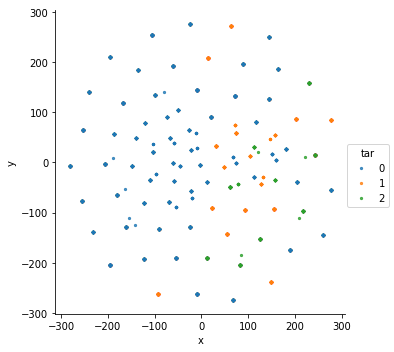

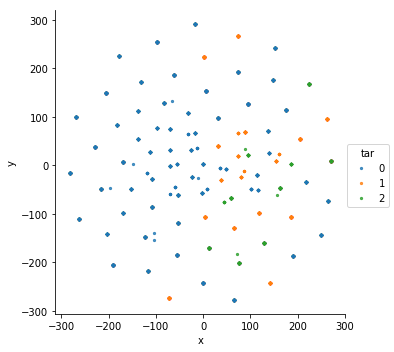

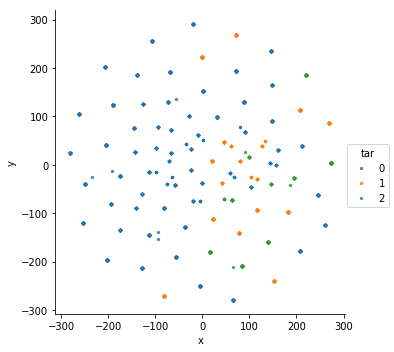

In [5]:
df_data = []
for plot_data in all_data:
    fc1_x = tsne(plot_data)
    df_data.append(plot(fc1_x, hole_tar))

,x,y,tar
0,-94.726952,-153.805542,0
1,-233.203186,-25.757322,0
2,64.513443,-210.559311,2
3,187.058975,-41.397705,2
4,-93.506172,-138.311157,0
5,91.077682,26.304379,2
6,-55.085449,136.327179,0
7,-191.488190,-13.074371,0
8,273.708221,3.887890,2
9,-66.715836,71.080894,0


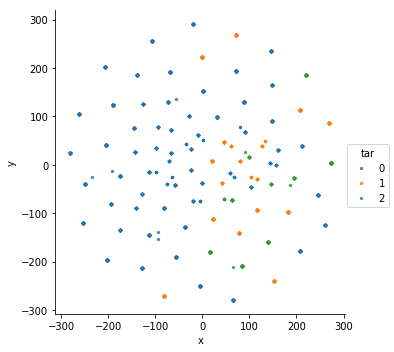

In [6]:
df = plot(fc1_x, hole_tar)
df.head(50)

测试网络 dead relu的个数

In [7]:
for it in iter_num:
    net_sl, net_rl, maddpg = load_model(it)
    for p in range(game_settings.player_count):
        current_params = parameters_to_vector(maddpg.actors[p].parameters())
        current_params = parameters_to_vector(maddpg.critics[p].parameters())
        dead_num = np.count_nonzero(np.less(current_params.data.cpu().numpy(), 0))
        print('total: %d dead: %d' % (current_params.shape[0], dead_num))

total: 1101159 dead: 175319
total: 1101159 dead: 174837
total: 1101159 dead: 175155
total: 1101159 dead: 175123
total: 1101159 dead: 174616
total: 1101159 dead: 175301
total: 1101159 dead: 175312
total: 1101159 dead: 174194
total: 1101159 dead: 175372


In [8]:
for state_tensor in data:
    print(maddpg.actors[2](Variable(state_tensor)).data)


-6.6606 -6.4496  2.7855 -1.6812 -4.5223  7.3005  4.4915
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6280 -6.4179  2.7718 -1.6729 -4.5001  7.2648  4.4695
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7082 -5.5273  2.3867 -1.4407 -3.8754  6.2580  3.8501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6250 -5.4467  2.3519 -1.4197 -3.8189  6.1669  3.7941
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6606 -6.4496  2.7855 -1.6812 -4.5223  7.3005  4.4915
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.2740 -6.0751  2.6236 -1.5835 -4.2597  6.8772  4.2311
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6883 -6.4763  2.7971 -1.6881 -4.5411  7.3308  4.5102
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6556 -6.4447  2.7834 -1.6799 -4.5189  7.2950  4.4882
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


1.00000e-02 *
 -7.2157 -6.9540  2.7067 -1.7940 -4.7617  8.8827  5.4217
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5588 -6.3509  2.7429 -1.6554 -4.4531


-5.6250 -5.4467  2.3519 -1.4197 -3.8189  6.1669  3.7941
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6931 -5.5126  2.3804 -1.4369 -3.8651  6.2414  3.8399
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5973 -5.4198  2.3403 -1.4127 -3.8001  6.1365  3.7754
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9906 -5.8007  2.5050 -1.5120 -4.0672  6.5671  4.0403
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6103 -5.4324  2.3457 -1.4160 -3.8089  6.1508  3.7841
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6578 -6.4468  2.7843 -1.6804 -4.5204  7.2974  4.4896
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7116 -5.5305  2.3882 -1.4416 -3.8777  6.2617  3.8523
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6233 -5.4450  2.3512 -1.4193 -3.8178  6.1650  3.7929
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9791 -5.7896  2.5002 -1.5091 -4.0594  6.5545  4.0325
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9241 -5.7363  2.4771 -1.4952 -4.0220  6.4943  3.995


-6.2478 -6.0498  2.6126 -1.5769 -4.2419  6.8486  4.2135
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6250 -5.4467  2.3519 -1.4197 -3.8189  6.1669  3.7941
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6556 -6.4447  2.7834 -1.6799 -4.5189  7.2950  4.4882
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9443 -5.7559  2.4856 -1.5003 -4.0358  6.5165  4.0091
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5774 -6.3690  2.7506 -1.6601 -4.4657  7.2094  4.4355
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6606 -6.4496  2.7855 -1.6812 -4.5223  7.3005  4.4915
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5988 -5.4214  2.3410 -1.4131 -3.8012  6.1383  3.7764
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6715 -6.4601  2.7900 -1.6839 -4.5296  7.3123  4.4988
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6927 -6.4807  2.7989 -1.6893 -4.5441  7.3356  4.5132
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7117 -5.5306  2.3882 -1.4416 -3.8778  6.2618  3.852


-5.9993 -5.8092  2.5086 -1.5142 -4.0731  6.5766  4.0461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


1.00000e-02 *
 -7.2157 -6.9540  2.7067 -1.7940 -4.7617  8.8827  5.4217
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6915 -5.5111  2.3797 -1.4365 -3.8641  6.2397  3.8388
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6931 -5.5126  2.3804 -1.4369 -3.8651  6.2414  3.8399
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9443 -5.7559  2.4856 -1.5003 -4.0358  6.5165  4.0091
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7030 -5.5222  2.3846 -1.4394 -3.8719  6.2523  3.8466
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6759 -6.4643  2.7919 -1.6850 -4.5326  7.3172  4.5018
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6233 -5.4450  2.3512 -1.4193 -3.8178  6.1650  3.7929
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0051 -5.8148  2.5111 -1.5157 -4.0771


-5.6250 -5.4467  2.3519 -1.4197 -3.8189  6.1669  3.7941
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.2663 -6.0677  2.6204 -1.5816 -4.2544  6.8688  4.2259
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


1.00000e-02 *
 -7.2157 -6.9540  2.7067 -1.7940 -4.7617  8.8827  5.4217
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6280 -6.4179  2.7718 -1.6729 -4.5001  7.2648  4.4695
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9285 -5.7406  2.4790 -1.4963 -4.0250  6.4991  3.9984
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9291 -5.7412  2.4792 -1.4965 -4.0255  6.4998  3.9989
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6174 -5.4393  2.3487 -1.4178 -3.8137  6.1585  3.7889
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9992 -5.8091  2.5086 -1.5142 -4.0731  6.5765  4.0461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6915 -5.5111  2.3797 -1.4365 -3.8641  6.2397  3.8388
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9399 -5.7517  2.4838 -1.4992 -4.0328


-6.0051 -5.8148  2.5111 -1.5157 -4.0771  6.5830  4.0501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6556 -6.4447  2.7834 -1.6799 -4.5189  7.2950  4.4882
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7082 -5.5273  2.3867 -1.4407 -3.8754  6.2580  3.8501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6556 -6.4447  2.7834 -1.6799 -4.5189  7.2950  4.4882
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6081 -5.4304  2.3448 -1.4155 -3.8075  6.1484  3.7827
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6140 -5.4360  2.3473 -1.4169 -3.8114  6.1548  3.7866
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5988 -5.4214  2.3410 -1.4131 -3.8012  6.1383  3.7764
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


1.00000e-02 *
 -7.2157 -6.9540  2.7067 -1.7940 -4.7617


-5.7175 -5.5363  2.3906 -1.4431 -3.8818  6.2682  3.8564
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9098 -5.7225  2.4712 -1.4916 -4.0124  6.4787  3.9859
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5973 -5.4198  2.3403 -1.4127 -3.8001  6.1365  3.7754
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6606 -6.4496  2.7855 -1.6812 -4.5223  7.3005  4.4915
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7103 -6.4977  2.8063 -1.6937 -4.5560  7.3549  4.5250
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5780 -6.3696  2.7509 -1.6603 -4.4662  7.2101  4.4359
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6915 -5.5111  2.3797 -1.4365 -3.8641  6.2397  3.8388
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5730 -6.3647  2.7488 -1.6590 -4.4628  7.2046  4.4325
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5774 -6.3690  2.7506 -1.6601 -4.4657  7.2094  4.4355
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0069 -5.8165  2.5118 -1.5161 -4.0783  6.5849  4.051


-6.7211 -6.5082  2.8108 -1.6964 -4.5634  7.3667  4.5323
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7082 -5.5273  2.3867 -1.4407 -3.8754  6.2580  3.8501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6931 -5.5126  2.3804 -1.4369 -3.8651  6.2414  3.8399
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5588 -6.3509  2.7429 -1.6554 -4.4531  7.1890  4.4229
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0069 -5.8165  2.5118 -1.5161 -4.0783  6.5849  4.0512
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7045 -5.5237  2.3852 -1.4398 -3.8729  6.2539  3.8476
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6883 -6.4763  2.7971 -1.6881 -4.5411  7.3308  4.5102
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7030 -5.5222  2.3846 -1.4394 -3.8719  6.2523  3.8466
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6386 -6.4282  2.7763 -1.6756 -4.5073  7.2764  4.4767
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6386 -6.4282  2.7763 -1.6756 -4.5073  7.2764  4.476


-5.6175 -5.4394  2.3487 -1.4178 -3.8138  6.1586  3.7890
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6233 -5.4450  2.3512 -1.4193 -3.8178  6.1650  3.7929
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5933 -6.3843  2.7573 -1.6642 -4.4765  7.2268  4.4462
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7211 -6.5082  2.8108 -1.6964 -4.5634  7.3667  4.5323
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9921 -5.8022  2.5056 -1.5124 -4.0682  6.5687  4.0413
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7211 -6.5082  2.8108 -1.6964 -4.5634  7.3667  4.5323
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9921 -5.8022  2.5056 -1.5124 -4.0682  6.5687  4.0413
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5588 -6.3509  2.7429 -1.6554 -4.4531  7.1890  4.4229
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9443 -5.7559  2.4856 -1.5003 -4.0358  6.5165  4.009


-5.9098 -5.7225  2.4712 -1.4916 -4.0124  6.4787  3.9859
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5752 -6.3668  2.7497 -1.6596 -4.4643  7.2070  4.4340
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6140 -5.4360  2.3473 -1.4169 -3.8114  6.1548  3.7866
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6927 -6.4807  2.7989 -1.6893 -4.5441  7.3356  4.5132
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6175 -5.4394  2.3487 -1.4178 -3.8138  6.1586  3.7890
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5454 -6.3380  2.7372 -1.6521 -4.4440  7.1743  4.4139
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7175 -5.5363  2.3906 -1.4431 -3.8818  6.2682  3.8564
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5780 -6.3696  2.7509 -1.6603 -4.4662  7.2101  4.4359
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6883 -6.4763  2.7971 -1.6881 -4.5411  7.3308  4.5102
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7030 -5.5222  2.3846 -1.4394 -3.8719  6.2523  3.846


-6.6578 -6.4468  2.7843 -1.6804 -4.5204  7.2974  4.4896
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6915 -5.5111  2.3797 -1.4365 -3.8641  6.2397  3.8388
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5933 -6.3843  2.7573 -1.6642 -4.4765  7.2268  4.4462
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7256 -6.5124  2.8127 -1.6976 -4.5664  7.3716  4.5353
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7097 -6.4971  2.8060 -1.6935 -4.5556  7.3542  4.5246
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9992 -5.8091  2.5086 -1.5142 -4.0731  6.5765  4.0461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5973 -5.4198  2.3403 -1.4127 -3.8001  6.1365  3.7754
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7116 -5.5305  2.3882 -1.4416 -3.8777  6.2617  3.8523
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0069 -5.8165  2.5118 -1.5161 -4.0783  6.5849  4.051


-5.8964 -5.7096  2.4656 -1.4882 -4.0033  6.4640  3.9769
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9399 -5.7517  2.4838 -1.4992 -4.0328  6.5116  4.0061
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6927 -6.4807  2.7989 -1.6893 -4.5441  7.3356  4.5132
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6556 -6.4447  2.7834 -1.6799 -4.5189  7.2950  4.4882
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7082 -5.5273  2.3867 -1.4407 -3.8754  6.2580  3.8501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0051 -5.8148  2.5111 -1.5157 -4.0771  6.5830  4.0501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9921 -5.8022  2.5056 -1.5124 -4.0682  6.5687  4.0413
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5454 -6.3380  2.7372 -1.6521 -4.4440  7.1743  4.4139
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6431 -6.4325  2.7781 -1.6767 -4.5103  7.2813  4.479


-6.6431 -6.4325  2.7781 -1.6767 -4.5103  7.2813  4.4797
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6088 -5.4310  2.3451 -1.4156 -3.8079  6.1491  3.7831
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7053 -6.4928  2.8042 -1.6924 -4.5526  7.3494  4.5216
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6883 -6.4763  2.7971 -1.6881 -4.5411  7.3308  4.5102
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9993 -5.8092  2.5086 -1.5142 -4.0731  6.5766  4.0461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7024 -5.5216  2.3843 -1.4393 -3.8714  6.2516  3.8461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5973 -5.4198  2.3403 -1.4127 -3.8001  6.1365  3.7754
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6777 -6.4661  2.7926 -1.6855 -4.5338  7.3191  4.5030
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9993 -5.8092  2.5086 -1.5142 -4.0731  6.5766  4.0461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6250 -5.4467  2.3519 -1.4197 -3.8189  6.1669  3.794


-5.6081 -5.4304  2.3448 -1.4155 -3.8075  6.1484  3.7827
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9791 -5.7896  2.5002 -1.5091 -4.0594  6.5545  4.0325
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7045 -5.5237  2.3852 -1.4398 -3.8729  6.2539  3.8476
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6600 -6.4489  2.7852 -1.6810 -4.5218  7.2998  4.4911
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9900 -5.8001  2.5047 -1.5119 -4.0668  6.5664  4.0398
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0051 -5.8148  2.5111 -1.5157 -4.0771  6.5830  4.0501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6174 -5.4393  2.3487 -1.4178 -3.8137  6.1585  3.7889
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7175 -5.5363  2.3906 -1.4431 -3.8818  6.2682  3.8564
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7116 -5.5305  2.3882 -1.4416 -3.8777  6.2617  3.8523
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7030 -5.5222  2.3846 -1.4394 -3.8719  6.2523  3.846


-6.6386 -6.4282  2.7763 -1.6756 -4.5073  7.2764  4.4767
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7053 -6.4928  2.8042 -1.6924 -4.5526  7.3494  4.5216
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6175 -5.4394  2.3487 -1.4178 -3.8138  6.1586  3.7890
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6280 -6.4179  2.7718 -1.6729 -4.5001  7.2648  4.4695
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9992 -5.8091  2.5086 -1.5142 -4.0731  6.5765  4.0461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.2592 -6.0608  2.6174 -1.5798 -4.2496  6.8611  4.2212
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5454 -6.3380  2.7372 -1.6521 -4.4440  7.1743  4.4139
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9958 -5.8058  2.5072 -1.5133 -4.0708  6.5728  4.0438
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7030 -5.5222  2.3846 -1.4394 -3.8719  6.2523  3.8466
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9791 -5.7896  2.5002 -1.5091 -4.0594  6.5545  4.032


-6.5730 -6.3647  2.7488 -1.6590 -4.4628  7.2046  4.4325
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6777 -6.4661  2.7926 -1.6855 -4.5338  7.3191  4.5030
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6386 -6.4282  2.7763 -1.6756 -4.5073  7.2764  4.4767
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6931 -5.5126  2.3804 -1.4369 -3.8651  6.2414  3.8399
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6883 -6.4763  2.7971 -1.6881 -4.5411  7.3308  4.5102
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6927 -6.4807  2.7989 -1.6893 -4.5441  7.3356  4.5132
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6250 -5.4467  2.3519 -1.4197 -3.8189  6.1669  3.7941
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6931 -5.5126  2.3804 -1.4369 -3.8651  6.2414  3.8399
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.0051 -5.8148  2.5111 -1.5157 -4.0771  6.5830  4.0501
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9071 -5.7198  2.4700 -1.4909 -4.0105  6.4756  3.984


-5.9115 -5.7242  2.4719 -1.4921 -4.0135  6.4805  3.9870
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6715 -6.4601  2.7900 -1.6839 -4.5296  7.3123  4.4988
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7030 -5.5222  2.3846 -1.4394 -3.8719  6.2523  3.8466
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9115 -5.7242  2.4719 -1.4921 -4.0135  6.4805  3.9870
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7116 -5.5305  2.3882 -1.4416 -3.8777  6.2617  3.8523
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6759 -6.4643  2.7919 -1.6850 -4.5326  7.3172  4.5018
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9921 -5.8022  2.5056 -1.5124 -4.0682  6.5687  4.0413
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7097 -6.4971  2.8060 -1.6935 -4.5556  7.3542  4.5246
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9807 -5.7911  2.5008 -1.5095 -4.0605  6.5562  4.0336
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6233 -5.4450  2.3512 -1.4193 -3.8178  6.1650  3.792


-5.9921 -5.8022  2.5056 -1.5124 -4.0682  6.5687  4.0413
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6777 -6.4661  2.7926 -1.6855 -4.5338  7.3191  4.5030
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7024 -5.5216  2.3843 -1.4393 -3.8714  6.2516  3.8461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9285 -5.7406  2.4790 -1.4963 -4.0250  6.4991  3.9984
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.5774 -6.3690  2.7506 -1.6601 -4.4657  7.2094  4.4355
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6431 -6.4325  2.7781 -1.6767 -4.5103  7.2813  4.4797
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.5973 -5.4198  2.3403 -1.4127 -3.8001  6.1365  3.7754
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6927 -6.4807  2.7989 -1.6893 -4.5441  7.3356  4.5132
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6911 -6.4790  2.7982 -1.6888 -4.5429  7.3338  4.5120
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6759 -6.4643  2.7919 -1.6850 -4.5326  7.3172  4.501


-6.6600 -6.4489  2.7852 -1.6810 -4.5218  7.2998  4.4911
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6606 -6.4496  2.7855 -1.6812 -4.5223  7.3005  4.4915
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6915 -5.5111  2.3797 -1.4365 -3.8641  6.2397  3.8388
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6911 -6.4790  2.7982 -1.6888 -4.5429  7.3338  4.5120
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7045 -5.5237  2.3852 -1.4398 -3.8729  6.2539  3.8476
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6280 -6.4179  2.7718 -1.6729 -4.5001  7.2648  4.4695
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.2629 -6.0644  2.6190 -1.5808 -4.2522  6.8651  4.2237
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6556 -6.4447  2.7834 -1.6799 -4.5189  7.2950  4.4882
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7211 -6.5082  2.8108 -1.6964 -4.5634  7.3667  4.5323
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9993 -5.8092  2.5086 -1.5142 -4.0731  6.5766  4.046


-5.7175 -5.5363  2.3906 -1.4431 -3.8818  6.2682  3.8564
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9071 -5.7198  2.4700 -1.4909 -4.0105  6.4756  3.9840
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7024 -5.5216  2.3843 -1.4393 -3.8714  6.2516  3.8461
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9906 -5.8007  2.5050 -1.5120 -4.0672  6.5671  4.0403
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.6233 -5.4450  2.3512 -1.4193 -3.8178  6.1650  3.7929
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9906 -5.8007  2.5050 -1.5120 -4.0672  6.5671  4.0403
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7193 -5.5380  2.3914 -1.4435 -3.8829  6.2701  3.8575
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6414 -6.4309  2.7774 -1.6763 -4.5092  7.2794  4.4786
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7211 -6.5082  2.8108 -1.6964 -4.5634  7.3667  4.5323
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7053 -6.4928  2.8042 -1.6924 -4.5526  7.3494  4.521


-5.6175 -5.4394  2.3487 -1.4178 -3.8138  6.1586  3.7890
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.7075 -6.4949  2.8051 -1.6930 -4.5541  7.3518  4.5231
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.2462 -6.0482  2.6120 -1.5765 -4.2408  6.8469  4.2124
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7116 -5.5305  2.3882 -1.4416 -3.8777  6.2617  3.8523
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6759 -6.4643  2.7919 -1.6850 -4.5326  7.3172  4.5018
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7193 -5.5380  2.3914 -1.4435 -3.8829  6.2701  3.8575
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9115 -5.7242  2.4719 -1.4921 -4.0135  6.4805  3.9870
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.7193 -5.5380  2.3914 -1.4435 -3.8829  6.2701  3.8575
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-5.9807 -5.7911  2.5008 -1.5095 -4.0605  6.5562  4.0336
[torch.cuda.FloatTensor of size (1,7) (GPU 0)]


-6.6715 -6.4601  2.7900 -1.6839 -4.5296  7.3123  4.498